<a href="https://colab.research.google.com/github/semudd3/GDS_MuddSandoval/blob/main/GDS_MuddSandoval_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [1]:
import os
import glob
import time
import random
import itertools
from functools import reduce
from copy import deepcopy

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import tensorflow as tf
from tensorflow.keras import layers, callbacks, backend as K

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Mount drive to access relevant data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Find Closest Basins to Durham

In [3]:
df_basins = gpd.read_file('/content/drive/MyDrive/GDS Final Project/Relevant Data/Basin Shapefiles/HCDN_nhru_final_671.shp')

durham_lat, durham_lon = 35.978611, -78.9
pt = gpd.GeoDataFrame({'name': ['Durham']},
                      geometry=[Point(durham_lon, durham_lat)],
                      crs="EPSG:4326")

metric_crs = "EPSG:3857"
df_basins_metric = df_basins.to_crs(metric_crs).copy()
pt_metric = pt.to_crs(metric_crs)

df_basins_metric["centroid_geom"] = df_basins_metric.geometry.centroid
df_basins_metric["dist_m"] = df_basins_metric["centroid_geom"].distance(pt_metric.loc[0, "geometry"])

N = 30
available = len(df_basins_metric)
N_use = min(N, available)

nearest_metric = df_basins_metric.nsmallest(N_use, "dist_m").copy()

nearest_original = df_basins.loc[nearest_metric.index].copy()
nearest_original["distance_m"] = nearest_metric["dist_m"].values
nearest_original["distance_km"] = nearest_original["distance_m"] / 1000.0

if "centroid_geom" in nearest_original.columns:
    nearest_original = nearest_original.drop(columns=["centroid_geom"], errors="ignore")

nearest_original = nearest_original.reset_index(drop=True)

print(f"Returning {len(nearest_original)} closest basins to Durham (sorted by centroid distance):")
display(nearest_original)

Returning 30 closest basins to Durham (sorted by centroid distance):


,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry,distance_m,distance_km
0,2096846,0.0,-79.18314,36.00844,1.958037e+07,222.947368,NaN,NaN,31175,"MULTIPOLYGON (((-79.16187 36.02448, -79.16193 ...",31785.687329,31.785687
1,2081500,0.0,-78.71923,36.30158,4.328267e+08,147.758065,NaN,NaN,186417,"MULTIPOLYGON (((-78.57227 36.1902, -78.57194 3...",48864.904534,48.864905
2,2077200,0.0,-79.22655,36.30010,1.263447e+08,190.341463,NaN,NaN,107493,"POLYGON ((-79.28844 36.25116, -79.28812 36.251...",57321.535474,57.321535
3,2082950,0.0,-77.94634,36.34491,4.619268e+08,88.517241,NaN,NaN,202720,"POLYGON ((-77.90491 36.44187, -77.90498 36.441...",117564.300595,117.564301
4,2102908,0.0,-79.20346,35.15365,2.006105e+07,98.944444,NaN,NaN,34443,"POLYGON ((-79.17291 35.18646, -79.17274 35.186...",117843.274484,117.843274
5,2128000,0.0,-79.83953,35.52624,2.719986e+08,218.682657,NaN,NaN,150667,"POLYGON ((-79.82227 35.69167, -79.82233 35.691...",121603.996283,121.603996
6,2074500,0.0,-79.60934,36.69510,2.887971e+08,243.847222,NaN,NaN,148466,"POLYGON ((-79.58116 36.8312, -79.58122 36.8309...",126650.554223,126.650554
7,2051500,0.0,-78.21324,36.86531,1.432434e+09,119.143975,NaN,NaN,390849,"MULTIPOLYGON (((-78.17592 36.76207, -78.17599 ...",144559.464806,144.559465
8,2051000,0.0,-78.37505,37.05035,1.451061e+08,148.056738,NaN,NaN,102520,"POLYGON ((-78.32589 37.1032, -78.32595 37.1029...",159537.801123,159.537801
9,2070000,0.0,-80.07252,36.66006,2.792742e+08,331.985612,NaN,NaN,135278,"POLYGON ((-80.13956 36.7538, -80.13963 36.7535...",160943.226296,160.943226


Extract text files (meteorological forcing data and static catchment attributes)

In [4]:
folder_path = "/content/drive/MyDrive/GDS Final Project/Relevant Data"
os.chdir(folder_path)

text_files = glob.glob("camels*.txt")
print("Found text files:", text_files)

dfs = {}
for file_path in text_files:
    df = pd.read_csv(file_path, sep=';')
    dfs[file_path] = df

Found text files: ['camels_vege.txt', 'camels_topo.txt', 'camels_soil.txt', 'camels_name.txt', 'camels_hydro.txt', 'camels_geol.txt', 'camels_clim.txt']


Create individual dfs to work with

In [5]:
df_vege = dfs['camels_vege.txt']
df_topo = dfs['camels_topo.txt']
df_soil = dfs['camels_soil.txt']
df_name = dfs['camels_name.txt']
df_hydro = dfs['camels_hydro.txt']
df_geol = dfs['camels_geol.txt']
df_clim = dfs['camels_clim.txt']

Read in basin physical characteristic file

Merge dataframes to create 1 dataframe containing static basin attributes

In [6]:
dfs = [df_vege, df_topo, df_soil, df_name, df_hydro, df_geol, df_clim]

df_static = reduce(lambda left, right: pd.merge(left, right, on="gauge_id", how="inner"), dfs)

print(df_static.shape)
df_static.head()

(671, 60)


,gauge_id,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99,...,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing
0,1013500,0.9063,4.167304,3.340732,0.804567,0.371648,0.883452,Mixed Forests,NaN,NaN,...,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,3.427119,mam
1,1022500,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444,...,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja
2,1030500,0.8782,4.685200,3.665543,0.858502,0.351393,0.975258,Mixed Forests,NaN,NaN,...,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,3.514262,djf
3,1031500,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000,...,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,3.473644,djf
4,1047000,0.9906,5.086811,4.300978,0.891383,0.445473,0.850450,Mixed Forests,0.241027,2.340180,...,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,3.691706,djf


Filter to the gauges we want

In [7]:
basin_ids = nearest_original['hru_id'].tolist()
df_static_clean = df_static[df_static['gauge_id'].isin(basin_ids)].copy()

df_static_clean["gauge_id"] = (
    df_static_clean["gauge_id"]
        .astype(int)
        .astype(str)
        .str.zfill(8)
)
df_static_clean = df_static_clean.set_index('gauge_id')

print(df_static_clean.shape)

(30, 59)


Import Forcing Dataset (daily values)

In [8]:
basin_ids = ["0" + str(i) for i in nearest_original["hru_id"].tolist()]
base_path = "/content/drive/MyDrive/GDS Final Project/Relevant Data/Forcing"
forcing_data = {}

for gauge_id in basin_ids:
    file_path = os.path.join(base_path, f"{gauge_id}_lump_nldas_forcing_leap.txt")
    df = pd.read_csv(file_path, sep="\t", skiprows=3)
    df["date"] = pd.to_datetime(df["Year Mnth Day Hr"])
    df.set_index("date", inplace=True)
    df.drop(columns=["Year Mnth Day Hr"], inplace=True)
    forcing_data[gauge_id] = df
    print(f"Set index to date for {os.path.basename(file_path)}")

Set index to date for 02096846_lump_nldas_forcing_leap.txt
Set index to date for 02081500_lump_nldas_forcing_leap.txt
Set index to date for 02077200_lump_nldas_forcing_leap.txt
Set index to date for 02082950_lump_nldas_forcing_leap.txt
Set index to date for 02102908_lump_nldas_forcing_leap.txt
Set index to date for 02128000_lump_nldas_forcing_leap.txt
Set index to date for 02074500_lump_nldas_forcing_leap.txt
Set index to date for 02051500_lump_nldas_forcing_leap.txt
Set index to date for 02051000_lump_nldas_forcing_leap.txt
Set index to date for 02070000_lump_nldas_forcing_leap.txt
Set index to date for 02108000_lump_nldas_forcing_leap.txt
Set index to date for 02065500_lump_nldas_forcing_leap.txt
Set index to date for 02069700_lump_nldas_forcing_leap.txt
Set index to date for 02064000_lump_nldas_forcing_leap.txt
Set index to date for 02125000_lump_nldas_forcing_leap.txt
Set index to date for 02053200_lump_nldas_forcing_leap.txt
Set index to date for 02092500_lump_nldas_forcing_leap.t

Import Streamflow (Target) Dataset

In [9]:
file_path_flow = "/content/drive/MyDrive/GDS Final Project/Relevant Data/Streamflow"
flow_data = {}

for gauge_id in basin_ids:
    file_path = os.path.join(file_path_flow, f"{gauge_id}_streamflow_qc.txt")
    df_flow = pd.read_csv(file_path, sep=r"\s+", header=None,
                     names=["gauge_id", "year", "month", "day", "streamflow_cfs", "qc_flag"])
    df_flow["date"] = pd.to_datetime(df_flow[["year", "month", "day"]])
    df_flow.set_index("date", inplace=True)
    df_flow.drop(columns=["year", "month", "day"], inplace=True)
    flow_data[gauge_id] = df_flow
    print(f"Set index to date for {os.path.basename(file_path)}")

Set index to date for 02096846_streamflow_qc.txt
Set index to date for 02081500_streamflow_qc.txt
Set index to date for 02077200_streamflow_qc.txt
Set index to date for 02082950_streamflow_qc.txt
Set index to date for 02102908_streamflow_qc.txt
Set index to date for 02128000_streamflow_qc.txt
Set index to date for 02074500_streamflow_qc.txt
Set index to date for 02051500_streamflow_qc.txt
Set index to date for 02051000_streamflow_qc.txt
Set index to date for 02070000_streamflow_qc.txt
Set index to date for 02108000_streamflow_qc.txt
Set index to date for 02065500_streamflow_qc.txt
Set index to date for 02069700_streamflow_qc.txt
Set index to date for 02064000_streamflow_qc.txt
Set index to date for 02125000_streamflow_qc.txt
Set index to date for 02053200_streamflow_qc.txt
Set index to date for 02092500_streamflow_qc.txt
Set index to date for 02056900_streamflow_qc.txt
Set index to date for 02046000_streamflow_qc.txt
Set index to date for 02059500_streamflow_qc.txt
Set index to date fo

Filter out missing values and drop qc_flag column from flow data

In [10]:
for df_name, df in flow_data.items():
    filtered_df = df[df['qc_flag'] != 'M']
    processed_df = filtered_df.drop(columns='qc_flag', axis=1)
    flow_data[df_name] = processed_df

Convert all data to numeric

In [11]:
for basin_id, df in forcing_data.items():
    forcing_data[basin_id] = df.apply(pd.to_numeric, errors='coerce')

for basin_id, df in flow_data.items():
    flow_data[basin_id] = df.apply(pd.to_numeric, errors='coerce')


Merge forcing, streamflow, and static attribute datasets for ungauged prediction

In [12]:
merged_list = []
for basin_id, df_flow in flow_data.items():
    if basin_id not in forcing_data:
        continue
    df_forcing = forcing_data[basin_id]
    df_forcing.index = df_forcing.index.normalize()
    df_merged = df_forcing.join(df_flow, how='inner')
    df_merged['gauge_id'] = basin_id
    static_row = df_static_clean.loc[basin_id]
    for col, val in static_row.items():
        df_merged[col] = val
    merged_list.append(df_merged)
df_all = pd.concat(merged_list).sort_index()

Make sure gauge_id values match dtype/format

In [13]:
df_static.index = df_static.index.astype(str)

# Static Attributes, Select Predictor Variables (X), isolate target (y)

In [14]:
# Static catchment attributes: precip mean, pet mean, aridity index, precip seasonality, snow fraction, high precip frequency, high precip duration,
# low precip frequency, low precip duration, elevation, slope, area, forest fraction, lai max, lai difference, gvf max, gcf difference,
# soil depth (pelletier), soil depth (STATSGO), soil porosity, soil condutivity, max water content, sand fraction, silt fraction, clay fraction,
# carbonate rocks fraction, geological permeability

# Predictor Variables max air temp, min air temp, precip, radiation, vapor pressure (from LSTM model, meterological forcing data)

Define features & target

In [15]:
df_all.columns

static_cols = [
    'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow',
    'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
    'elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max', 'lai_diff',
    'gvf_max', 'gvf_diff', 'soil_depth_pelletier', 'soil_depth_statsgo',
    'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac',
    'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability'
]

dynamic_cols = [
    'Tmax(C)', 'Tmin(C)', 'PRCP(mm/day)', 'SRAD(W/m2)', 'Vp(Pa)', 'Dayl(s)'
]

target_col = 'streamflow_cfs'

Aggregate data for monthly max predictions, merging with static attributes

In [16]:
def aggregate_monthly(df_daily, static_cols, dynamic_cols, target_col):
    df = df_daily.copy()

    df_monthly = (
        df.groupby("gauge_id")
          .resample("ME")
          .agg({target_col: "max",
              'Tmax(C)': 'mean',
              'Tmin(C)': 'mean',
              'PRCP(mm/day)': 'sum',
              'SRAD(W/m2)': 'mean',
              'Vp(Pa)': 'mean',
              'Dayl(s)': 'mean'}))

    df_monthly.index = df_monthly.index.set_names(["gauge_id", "date"])
    static_df = df[["gauge_id"] + static_cols].drop_duplicates("gauge_id").set_index("gauge_id")
    df_monthly = df_monthly.join(static_df, on="gauge_id")

    return df_monthly

In [17]:
df_monthly = aggregate_monthly(df_all, static_cols, dynamic_cols, target_col)
df_monthly = df_monthly.dropna()

In [18]:
print(df_monthly.dtypes)
print(df_monthly['streamflow_cfs'].isna().sum())
print(df_monthly.groupby(level=0).size())

streamflow_cfs          float64
Tmax(C)                 float64
Tmin(C)                 float64
PRCP(mm/day)            float64
SRAD(W/m2)              float64
Vp(Pa)                  float64
Dayl(s)                 float64
p_mean                  float64
pet_mean                float64
aridity                 float64
p_seasonality           float64
frac_snow               float64
high_prec_freq          float64
high_prec_dur           float64
low_prec_freq           float64
low_prec_dur            float64
elev_mean               float64
slope_mean              float64
area_gages2             float64
frac_forest             float64
lai_max                 float64
lai_diff                float64
gvf_max                 float64
gvf_diff                float64
soil_depth_pelletier    float64
soil_depth_statsgo      float64
soil_porosity           float64
soil_conductivity       float64
max_water_content       float64
sand_frac               float64
silt_frac               float64
clay_fra

Create monthly sequences with 1 year lookback period

In [19]:
def build_sequences_monthly(df_basin, lookback=12):
    X_dyn = df_basin[dynamic_cols].values
    X_sta = df_basin[static_cols].iloc[0].values

    y = df_basin[[target_col]].values

    X_sta_tiled = np.tile(X_sta, (len(df_basin), 1))
    X = np.hstack([X_dyn, X_sta_tiled])

    X_seq, y_seq = [], []

    for i in range(
        lookback, len(df_basin)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

In [20]:
holdout_id = np.random.choice(df_monthly.index.get_level_values('gauge_id').unique(), size=6, replace=False)
print(holdout_id)

['02074500' '02038850' '02125000' '02081500' '02112120' '02069700']


In [1]:
holdout_id = ['02092500', '02112360', '02112120', '02056900', '02051500', '02082950'] # These are fixed to better evaluate model performance

Plot holdout basins

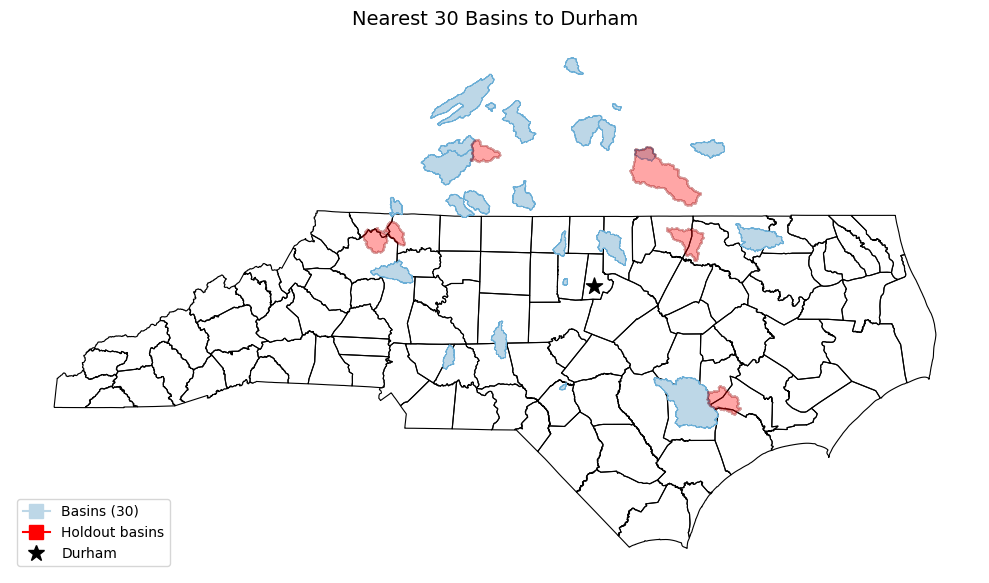

In [22]:
nc_shp_path = '/content/drive/MyDrive/GDS Final Project/Relevant Data/NC/North_Carolina_State_and_County_Boundary_Polygons.shp'
highlight_ids = ['02092500', '02112360', '02112120', '02056900', '02051500', '02082950']
nc_gdf = gpd.read_file(nc_shp_path).to_crs(nearest_original.crs)
pt_plot = pt.to_crs(nearest_original.crs)
basins30 = nearest_original.copy()
basins30['hru_id_str'] = basins30['hru_id'].astype(str).str.strip().str.zfill(8)
highlight_ids_z = [str(x).strip().zfill(8) for x in highlight_ids]
mask = basins30['hru_id_str'].isin(highlight_ids_z)
basins_highlight = basins30.loc[mask].copy()
basins_other = basins30.loc[~mask].copy()
fig, ax = plt.subplots(figsize=(10, 10))
nc_gdf.boundary.plot(ax=ax, color='black', linewidth=0.8, zorder=0)
basins_other.plot(ax=ax, facecolor='#bdd7e7', edgecolor='#6baed6', linewidth=0.6, zorder=1)
basins_highlight.plot(ax=ax, facecolor='red', edgecolor='darkred', linewidth=1.2, alpha=0.35, zorder=2)
pt_plot.plot(ax=ax, color='black', marker='*', markersize=150, zorder=3)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='#bdd7e7', markerfacecolor='#bdd7e7', markersize=10, label='Basins (30)'),
    Line2D([0], [0], marker='s', color='red', markerfacecolor='red', markersize=10, label='Holdout basins'),
    Line2D([0], [0], marker='*', color='k', label='Durham', markersize=12, linestyle='None')
]
ax.legend(handles=legend_elements, loc='lower left')
ax.set_title("Nearest 30 Basins to Durham", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Plot holdout basins and selected attributes/stats

In [44]:
forcing_plot = ['PRCP(mm/day)', 'Tmax(C)', 'SRAD(W/m2)', 'Vp(Pa)']
selected_basins = ['02092500', '02112360', '02112120', '02056900', '02051500', '02082950']

In [45]:
def get_real_stats(basin_id):
    static_row = df_all[df_all['gauge_id'] == basin_id].iloc[0]

    df_m = df_monthly.loc[df_monthly.index.get_level_values('gauge_id') == basin_id]
    forcing_mean = df_m[forcing_plot].mean()

    stats_dict = {
        "Area (km²)": static_row['area_gages2'],
        "Slope (m/km)": static_row['slope_mean'],
        "Forest (%)": static_row['frac_forest'] * 100 if static_row['frac_forest'] <= 1 else static_row['frac_forest'],
        "Mean Annual Precip (mm)": static_row['p_mean'] * 365,
        "Elevation (m)": static_row['elev_mean'],
        "Snow Fraction (%)": static_row['frac_snow'] * 100,
        "Soil Porosity": static_row['soil_porosity'],
        "Geologic Permeability": static_row['geol_permeability'],
        "Mean Tmax (°C)": forcing_mean['Tmax(C)'],}

    return stats_dict

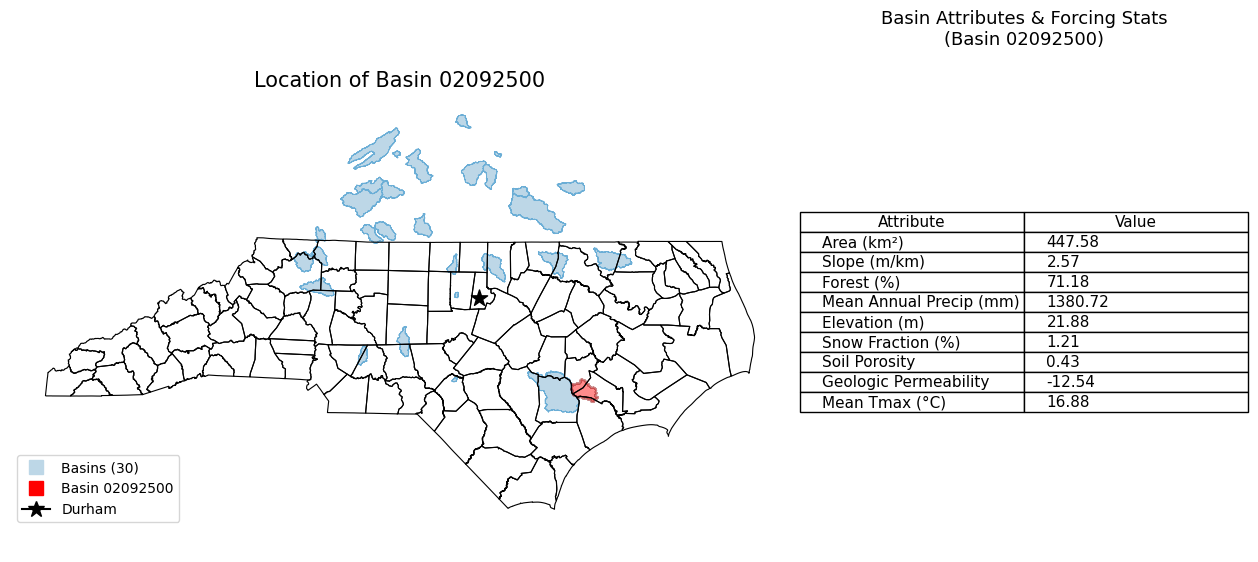

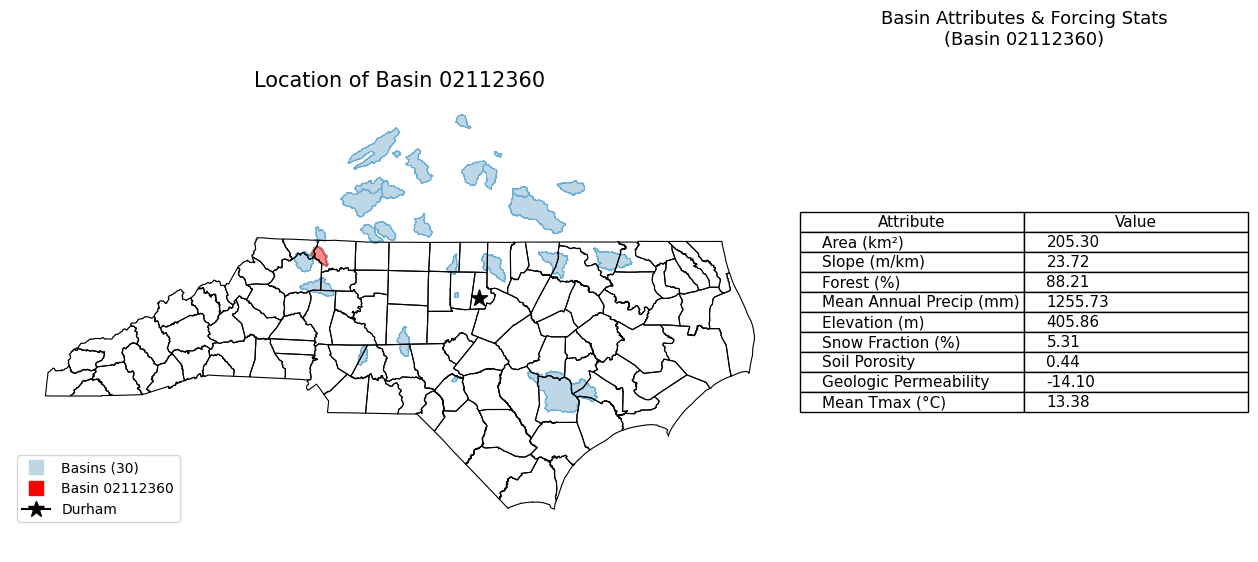

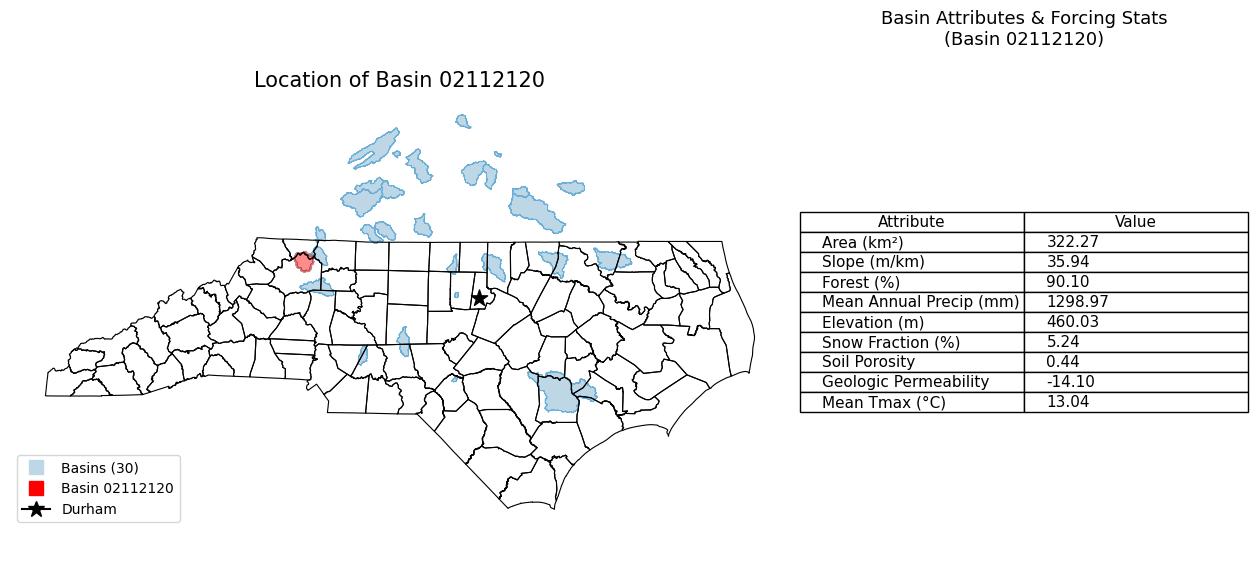

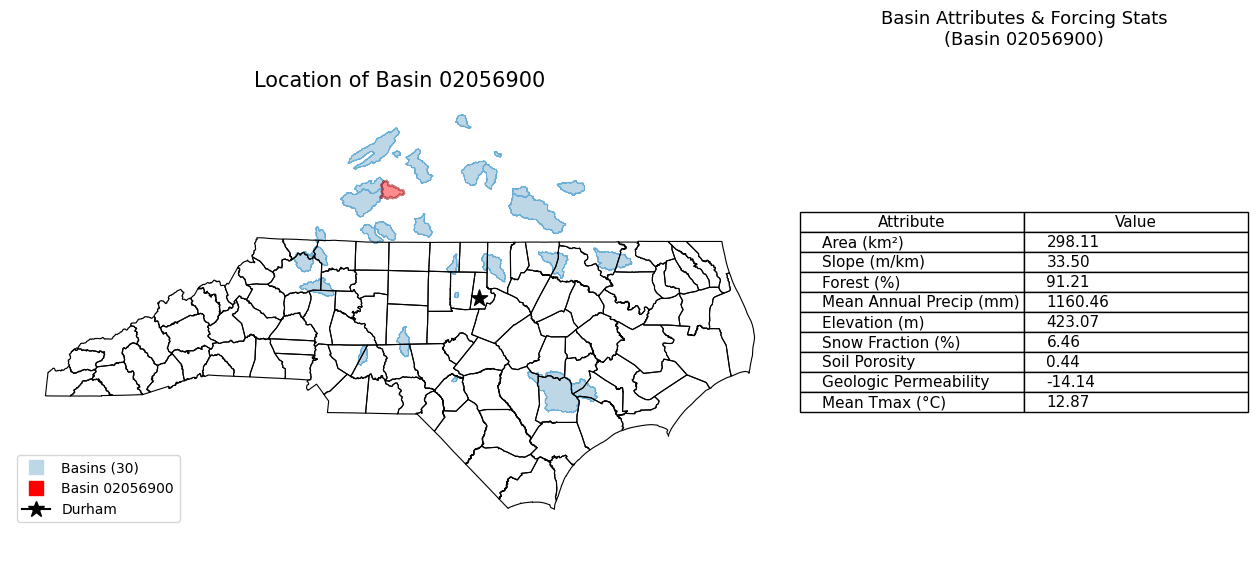

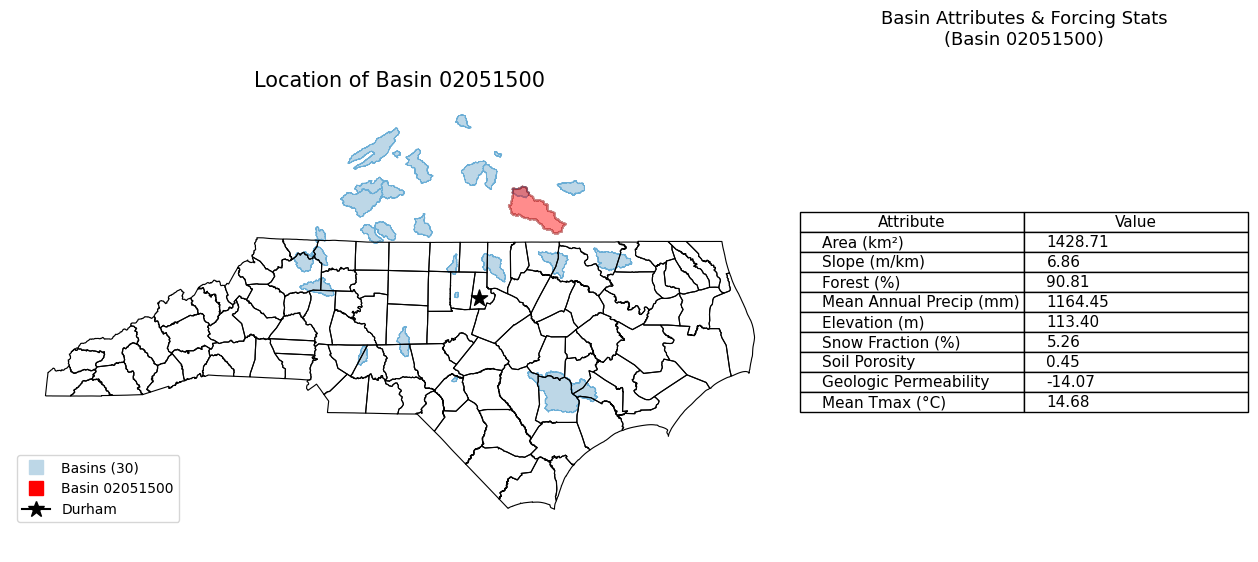

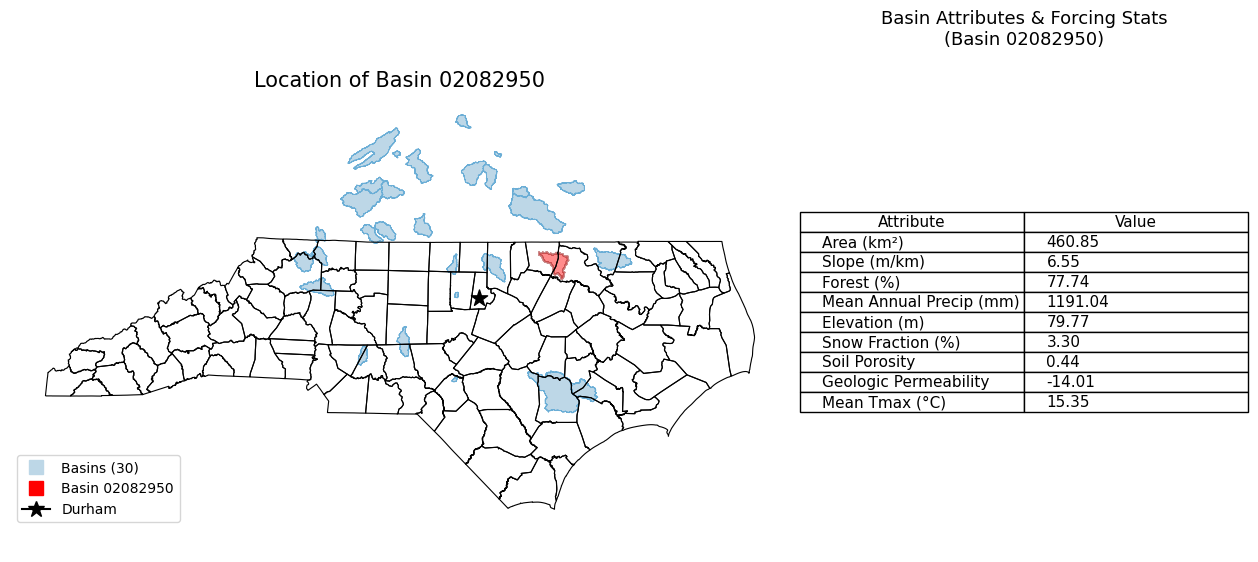

In [46]:
for basin_id in selected_basins:

    stats = get_real_stats(basin_id)

    mask = basins30["hru_id_str"] == basin_id
    basins_highlight = basins30.loc[mask]
    basins_other = basins30.loc[~mask]

    fig = plt.figure(figsize=(13, 8))

    ax_map = fig.add_axes([0.05, 0.05, 0.60, 0.90])

    nc_gdf.boundary.plot(ax=ax_map, color='black', linewidth=0.8)
    basins_other.plot(ax=ax_map, facecolor='#bdd7e7', edgecolor='#6baed6', linewidth=0.6)
    basins_highlight.plot(ax=ax_map, facecolor='red', edgecolor='darkred',
                          alpha=0.45, linewidth=1.2)
    pt_plot.plot(ax=ax_map, color='black', marker='*', markersize=150)

    legend_elements = [
        Line2D([0], [0], marker='s', color='#bdd7e7', markerfacecolor='#bdd7e7',
               linewidth=0, markersize=10, label='Basins (30)'),
        Line2D([0], [0], marker='s', color='red', markerfacecolor='red',
               linewidth=0, markersize=10, label=f"Basin {basin_id}"),
        Line2D([0], [0], marker='*', markersize=12, color='black', label='Durham')
    ]
    ax_map.legend(handles=legend_elements, loc='lower left')
    ax_map.set_title(f"Location of Basin {basin_id}", fontsize=15)
    ax_map.set_axis_off()

    ax_table = fig.add_axes([0.68, 0.20, 0.30, 0.60])
    ax_table.axis("off")

    labels = list(stats.keys())
    values = [f"{v:.2f}" if isinstance(v, float) else v for v in stats.values()]
    table_data = list(zip(labels, values))

    table = ax_table.table(
        cellText=table_data,
        colLabels=["Attribute", "Value"],
        loc='center',
        cellLoc='left'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.15, 1.20)

    ax_table.set_title(
        f"Basin Attributes & Forcing Stats\n(Basin {basin_id})",
        fontsize=13,
        pad=20
    )

    plt.show()

Build training data for all basins, holding out 6 basins for testing

In [26]:
X_all, y_all = [], []

for basin_id, df_basin in df_monthly.groupby('gauge_id'):
    if basin_id in holdout_id:
        continue
    Xb, yb = build_sequences_monthly(df_basin, lookback=12)
    X_all.append(Xb)
    y_all.append(yb)

X_train = np.concatenate(X_all, axis=0)
y_train = np.concatenate(y_all, axis=0)

nsamples = X_train.shape[0]
timesteps = X_train.shape[1]
nfeatures = X_train.shape[2]

scaler_X = StandardScaler().fit(X_train.reshape(-1, nfeatures))
y_train_log = np.log1p(y_train)
scaler_y_log = StandardScaler().fit(y_train_log)

X_train_scaled = scaler_X.transform(X_train.reshape(-1, nfeatures)).reshape(X_train.shape)

y_train_scaled = scaler_y_log.transform(y_train_log)

Build and train LSTM with hyperparameter search (output is errored due to terminated accidental rerun, as block takes ~.5hr to run)

In [27]:
def build_model(num_features, lookback, lstm_units, lstm_layers, dropout_rate, dense_units, lr):
    model = tf.keras.Sequential()
    for i in range(lstm_layers):
        return_seq = True if i < (lstm_layers - 1) else False
        if i == 0:
            model.add(layers.LSTM(lstm_units, return_sequences=return_seq, input_shape=(lookback, num_features)))
        else:
            model.add(layers.LSTM(lstm_units, return_sequences=return_seq))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

param_grid = {"dropout_rate": [0.1, 0.2, 0.3],
    "lr": [1e-3, 3e-4],
    "batch_size": [32, 64],
    "lstm_layers": [1, 2]}

lookback = 12
lstm_units = 64
dense_units = 32
epochs = 50
keys, values = zip(*param_grid.items())
combos = [dict(zip(keys, v)) for v in itertools.product(*values)]

results = []
best_val = np.inf
best_combo = None
best_weights = None

for i, combo in enumerate(combos, 1):
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    K.clear_session()
    model = build_model(num_features=nfeatures, lookback=lookback,
                        lstm_units=lstm_units,
                        lstm_layers=combo['lstm_layers'],
                        dropout_rate=combo['dropout_rate'],
                        dense_units=dense_units,
                        lr=combo['lr'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    start = time.time()
    print(f"Starting combo {i}/{len(combos)} {combo}")
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=epochs,
        batch_size=combo['batch_size'],
        validation_split=0.2,
        shuffle=True,
        callbacks=[es],
        verbose=1)
    elapsed = time.time() - start
    val_loss = min(history.history['val_loss'])
    val_mae = min(history.history['val_mae'])
    epochs_ran = len(history.history['loss'])
    print(f"Finished combo {i}/{len(combos)} val_loss={val_loss:.6f} val_mae={val_mae:.6f} epochs={epochs_ran} time_s={elapsed:.1f}")
    results.append({**combo, "val_loss": float(val_loss), "val_mae": float(val_mae), "epochs_ran": int(epochs_ran), "time_s": float(elapsed)})
    if val_loss < best_val:
        best_val = val_loss
        best_combo = combo.copy()
        best_weights = model.get_weights()

results_df = pd.DataFrame(results).sort_values('val_loss').reset_index(drop=True)
print("\nTop 5 configurations by validation loss:")
print(results_df.head(5))
print("\nBest combo:", best_combo)

Starting combo 1/24 {'dropout_rate': 0.1, 'lr': 0.001, 'batch_size': 32, 'lstm_layers': 1}
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6091 - mae: 0.6130 - val_loss: 0.6871 - val_mae: 0.6442
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4483 - mae: 0.5219 - val_loss: 0.6419 - val_mae: 0.6272
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.4475 - mae: 0.5217 - val_loss: 0.6630 - val_mae: 0.6444
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4345 - mae: 0.5119 - val_loss: 0.6410 - val_mae: 0.6362
Epoch 5/50
  1/240 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.5114 - mae: 0.5742

KeyboardInterrupt: 

In [28]:
# Did not set randomstate=42; therefore output values are not consistent
model = tf.keras.Sequential([
    layers.Input(shape=(12, nfeatures)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    shuffle=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,337 (243.50 KB)

 Trainable params: 62,337 (243.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.6821 - mae: 0.6504 - val_loss: 0.7277 - val_mae: 0.6499
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.4898 - mae: 0.5485 - val_loss: 0.6889 - val_mae: 0.6311
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4661 - mae: 0.5320 - val_loss: 0.6943 - val_mae: 0.6351
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4536 - mae: 0.5264 - val_loss: 0.6832 - val_mae: 0.6281
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.4394 - mae: 0.5179 - val_loss: 0.6746 - val_mae: 0.6235
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.4337 - mae: 0.5139 - val_loss: 0.6872 - val_mae: 0.6264
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.4336 - mae: 0.5132 - val_loss: 0.7093 - val_mae: 0.6356
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.4232 - mae: 0.5067 - val_loss: 0.6911 - val_mae: 0.6289
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/

Predict for the held-out (ungaged) basins

In [29]:
predictions = []

for basin_id in holdout_id:
    df_holdout = df_monthly.loc[df_monthly.index.get_level_values('gauge_id') == basin_id]
    Xh, yh = build_sequences_monthly(df_holdout, lookback=12)
    Xh_scaled = scaler_X.transform(Xh.reshape(-1, nfeatures)).reshape(Xh.shape)
    yh_log = np.log1p(yh)
    yh_scaled = scaler_y_log.transform(yh_log)

    pred_log_scaled = model.predict(Xh_scaled)
    pred_log = scaler_y_log.inverse_transform(pred_log_scaled)
    pred = np.expm1(pred_log)

    predictions.append({
        "basin_id": basin_id,
        "y_true": yh.reshape(-1),
        "y_pred": pred.reshape(-1)})

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Compute NSE and RMSE

In [30]:
for result in predictions:
    basin_id = result["basin_id"]
    yh = result["y_true"]
    pred = result["y_pred"]

    rmse = np.sqrt(np.mean((yh - pred)**2))
    nse  = 1 - np.sum((yh - pred)**2) / np.sum((yh - np.mean(yh))**2)

    print(f"\nBasin {basin_id}")
    print("RMSE:", rmse)
    print("NSE :", nse)


Basin 02092500
RMSE: 885.64792690266
NSE : 0.15845097225437677

Basin 02112360
RMSE: 424.56343032805535
NSE : -0.03621450926650893

Basin 02112120
RMSE: 757.7928100930853
NSE : -0.0070734591317300755

Basin 02056900
RMSE: 592.6767549536512
NSE : 0.41431315749296005

Basin 02051500
RMSE: 2383.1029919194657
NSE : 0.21071216005330073

Basin 02082950
RMSE: 958.622631075828
NSE : 0.4763551487448472


Plot predicted vs observed monthly max flow

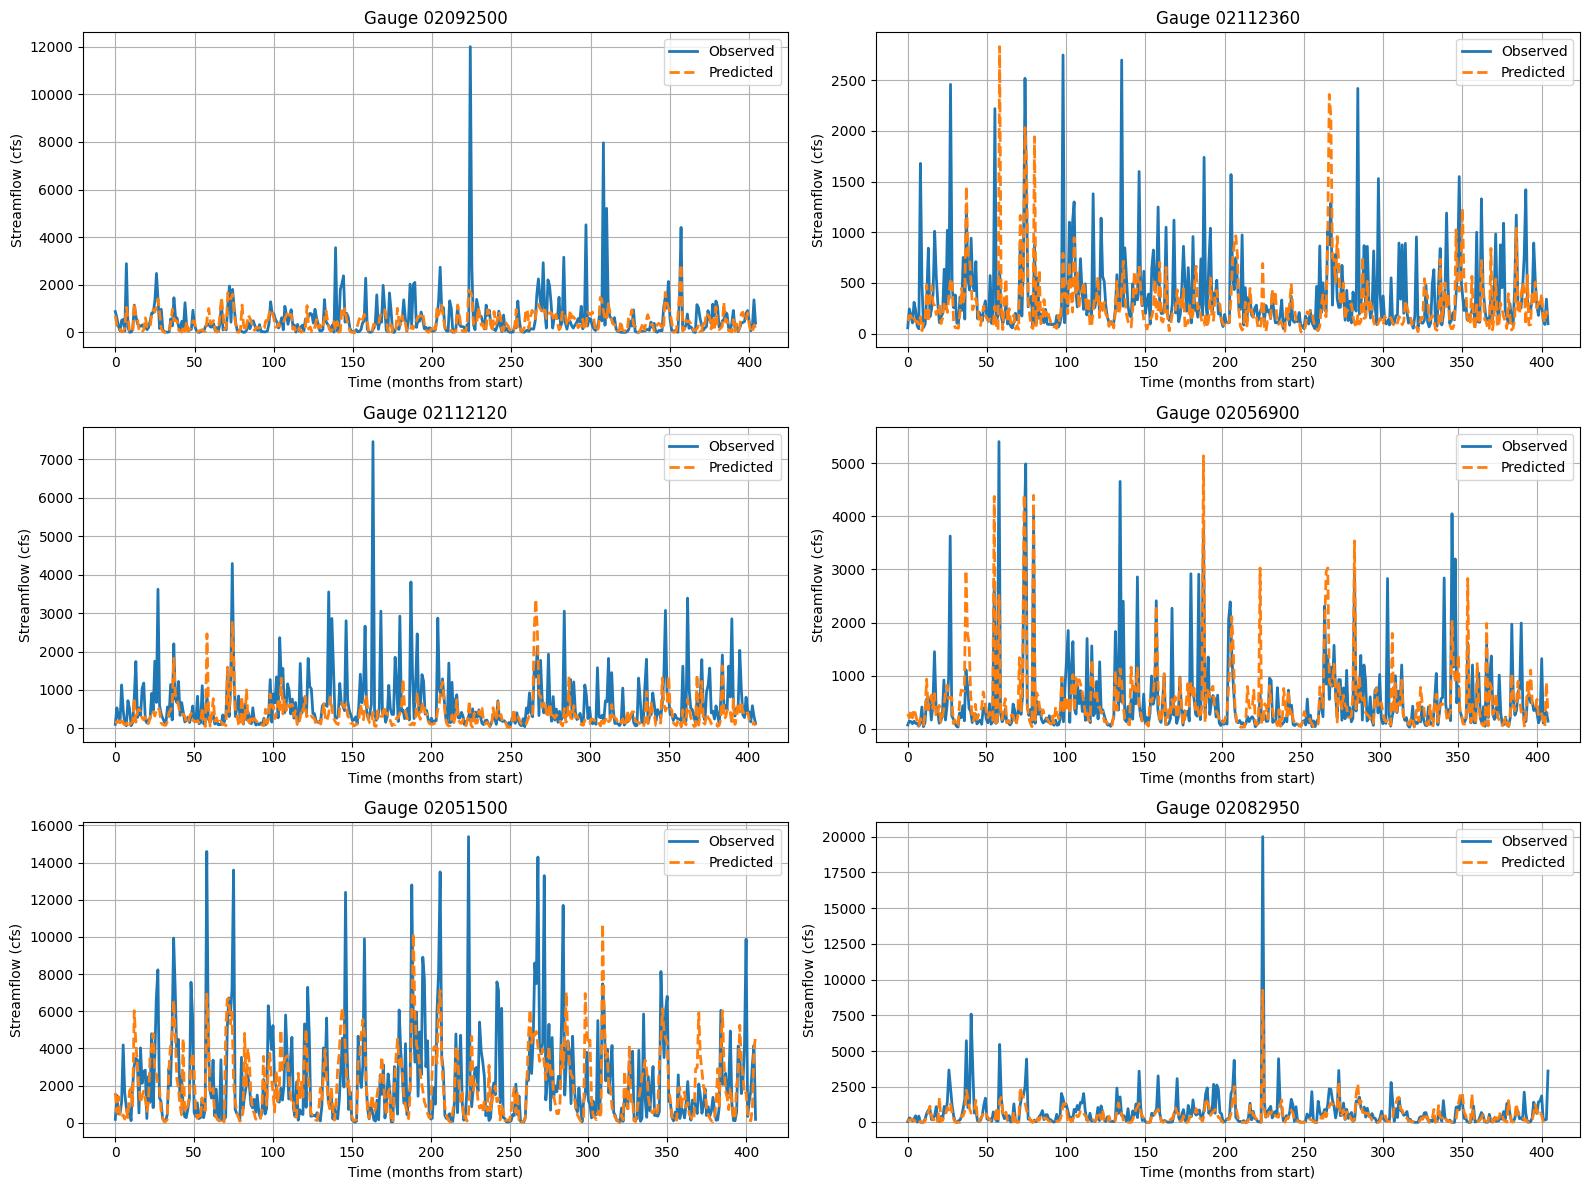

In [32]:
num_basins = len(predictions)
rows = 3
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, result in enumerate(predictions):
    basin_id = result["basin_id"]
    true = result["y_true"].flatten()
    pred_flat = result["y_pred"].flatten()
    ax = axes[i]
    ax.plot(true, label="Observed", linewidth=2)
    ax.plot(pred_flat, label="Predicted", linestyle='--', linewidth=2)
    ax.set_title(f"Gauge {basin_id}")
    ax.set_xlabel("Time (months from start)")
    ax.set_ylabel("Streamflow (cfs)")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

Calculate variable importance


In [41]:
def nse_score(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    denom = np.sum((y_true - np.mean(y_true))**2)
    if denom <= eps:
        return float("-inf")
    return 1.0 - np.sum((y_true - y_pred)**2) / denom

def inverse_transform_target(y_scaled, scaler_y):
    y_log = scaler_y.inverse_transform(y_scaled.reshape(-1, 1))
    y = np.expm1(y_log)
    return y.flatten()

def permutation_importance_lstm(model, X_val_scaled, y_val_scaled, scaler_y,
                                feature_names, n_repeats=1,
                                random_state=None, verbose=True):

    rng = np.random.default_rng(random_state)
    X_val_scaled = np.asarray(X_val_scaled)
    y_val_scaled = np.asarray(y_val_scaled).reshape(-1, 1)

    pred_scaled = model.predict(X_val_scaled, verbose=0)
    baseline_pred = inverse_transform_target(pred_scaled, scaler_y)
    baseline_true = inverse_transform_target(y_val_scaled, scaler_y)

    baseline_rmse = np.sqrt(np.mean((baseline_true - baseline_pred)**2))
    baseline_nse  = nse_score(baseline_true, baseline_pred)

    if verbose:
        print(f"Baseline RMSE = {baseline_rmse:.3f}")
        print(f"Baseline NSE  = {baseline_nse:.3f}\n")

    n_samples, timesteps, n_features = X_val_scaled.shape
    records = []

    for fidx, feat in enumerate(feature_names):
        if verbose:
            print(f"Permuting feature: {feat} ({fidx+1}/{n_features})")

        rmse_vals = []
        nse_vals  = []

        for _ in range(n_repeats):
            X_perm = deepcopy(X_val_scaled)
            for t in range(timesteps):
                X_perm[:, t, fidx] = rng.permutation(X_perm[:, t, fidx])

            perm_pred_scaled = model.predict(X_perm, verbose=0)
            perm_pred = inverse_transform_target(perm_pred_scaled, scaler_y)

            rmse = np.sqrt(np.mean((baseline_true - perm_pred)**2))
            nse  = nse_score(baseline_true, perm_pred)

            rmse_vals.append(rmse)
            nse_vals.append(nse)

        rmse_mean = np.mean(rmse_vals)
        nse_mean  = np.mean(nse_vals)

        records.append({
            "feature": feat,
            "delta_rmse": round(float(rmse_mean - baseline_rmse), 2),
            "delta_nse": round(float(baseline_nse - nse_mean), 2),
            "rmse_perm_mean": round(float(rmse_mean), 2),
            "nse_perm_mean": round(float(nse_mean), 2),
        })

    df = pd.DataFrame.from_records(records)
    df["delta_rmse"] = df["delta_rmse"].round(2)
    df["delta_nse"] = df["delta_nse"].round(2)
    df["rmse_perm_mean"] = df["rmse_perm_mean"].round(2)
    df["nse_perm_mean"] = df["nse_perm_mean"].round(2)
    df = df.sort_values("delta_rmse", ascending=False).reset_index(drop=True)
    return df

imp_df = permutation_importance_lstm(
    model,
    Xh_scaled,
    yh_scaled,
    scaler_y_log,
    feature_names,
    n_repeats=3,
    random_state=42,
    verbose=True)

print(imp_df.head(20))

Baseline RMSE = 958.623
Baseline NSE  = 0.476

Permuting feature: Tmax(C) (1/33)
Permuting feature: Tmin(C) (2/33)
Permuting feature: PRCP(mm/day) (3/33)
Permuting feature: SRAD(W/m2) (4/33)
Permuting feature: Vp(Pa) (5/33)
Permuting feature: Dayl(s) (6/33)
Permuting feature: p_mean (7/33)
Permuting feature: pet_mean (8/33)
Permuting feature: aridity (9/33)
Permuting feature: p_seasonality (10/33)
Permuting feature: frac_snow (11/33)
Permuting feature: high_prec_freq (12/33)
Permuting feature: high_prec_dur (13/33)
Permuting feature: low_prec_freq (14/33)
Permuting feature: low_prec_dur (15/33)
Permuting feature: elev_mean (16/33)
Permuting feature: slope_mean (17/33)
Permuting feature: area_gages2 (18/33)
Permuting feature: frac_forest (19/33)
Permuting feature: lai_max (20/33)
Permuting feature: lai_diff (21/33)
Permuting feature: gvf_max (22/33)
Permuting feature: gvf_diff (23/33)
Permuting feature: soil_depth_pelletier (24/33)
Permuting feature: soil_depth_statsgo (25/33)
Permuting